In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sdm.config import get_db_connection
from sdm.crud_embeddings import get_all_embeddings
from sdm.utils import get_pi_ba_dataframe

In [19]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [4]:
with get_db_connection(db_type="postgres") as db:
    df = get_all_embeddings(db)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36780 entries, 0 to 36779
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         36780 non-null  int64 
 1   text       36780 non-null  object
 2   doc_type   36780 non-null  object
 3   doc_id     36780 non-null  object
 4   embedding  36780 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [5]:
df.head()

,id,text,doc_type,doc_id,embedding
0,5321,$1 trillion funding gap for poorest countries’...,tweet,671780808412254210,"[-0.13590758, 0.17315766, -0.008780155, 0.1163..."
1,5322,$3.4 Trillion: #Fossil ]Fuel Divestment Commit...,tweet,672364415400828932,"[0.00019094069, 0.17916173, -0.0056449766, 0.0..."
2,5323,$3.4 Trillion: #Fossil ]Fuel Divestment Commit...,tweet,672449986647330816,"[-0.00010863412, 0.18258078, -0.005554083, 0.0..."
3,5324,"$#COP21, Sassou Nguesso franc et direct. #sass...",tweet,672759702690922496,"[-0.083288014, 0.12386762, -0.013259346, 0.041..."
4,5325,$#COP21: Suivons les négociations et nous verr...,tweet,673645638286835712,"[-0.041687813, 0.22417882, -0.011368999, -0.05..."


In [10]:
print(df["doc_type"].value_counts())

doc_type
tweet         31460
comment        5000
submission      320
Name: count, dtype: int64


In [11]:
tweet_df = df[df["doc_type"] == "tweet"]

In [9]:
com_sub_df = df[df["doc_type"] != "tweet"]
com_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 31460 to 36779
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5320 non-null   int64 
 1   text       5320 non-null   object
 2   doc_type   5320 non-null   object
 3   doc_id     5320 non-null   object
 4   embedding  5320 non-null   object
dtypes: int64(1), object(4)
memory usage: 249.4+ KB


In [6]:
with get_db_connection(db_type="postgres") as db:
    pi_ba_df = get_pi_ba_dataframe(db)
pi_ba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33692 entries, 0 to 33691
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    33692 non-null  object
 1   doc_id        33692 non-null  object
 2   account_type  33692 non-null  object
 3   lang          33692 non-null  object
 4   stance        33692 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [14]:
pi_df = pi_ba_df[pi_ba_df["account_type"] == "Private individuals"]
print(pi_df.shape)
ba_df = pi_ba_df[pi_ba_df["account_type"] == "Business actors"]
print(ba_df.shape)

(23611, 5)
(10081, 5)


In [15]:
pi_df = pd.merge(pi_df, tweet_df, how="left", on="doc_id")
pi_df = pi_df[pi_df["embedding"].notnull()]
print(pi_df.info())
pi_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 21945 entries, 0 to 23610
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account_id    21945 non-null  object 
 1   doc_id        21945 non-null  object 
 2   account_type  21945 non-null  object 
 3   lang          21945 non-null  object 
 4   stance        21945 non-null  object 
 5   id            21945 non-null  float64
 6   text          21945 non-null  object 
 7   doc_type      21945 non-null  object 
 8   embedding     21945 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.7+ MB
None


,account_id,doc_id,account_type,lang,stance,id,text,doc_type,embedding
0,2374469136,675825881600819200,Private individuals,fr,Unclear,15586.0,@JdeQuebec Vraiment le pot fait de mauvais eff...,tweet,"[-0.05918192, 0.22358717, -0.016498389, -0.029..."
1,74508903,675821381943238657,Private individuals,fr,Unclear,12552.0,"[Direct #COP21 ] @LaurentFabius ""la séance est...",tweet,"[-0.08324683, 0.14276661, -0.013592841, -0.009..."
4,74508903,675820988400066560,Private individuals,fr,Unclear,12549.0,[Direct #COP21 ] @LaurentFabius annonce la clô...,tweet,"[-0.15941124, -0.012673036, -0.009087384, 0.04..."
8,21150492,675820252685598720,Private individuals,en,Against,13489.0,"Finally, #COP21 ends... climate comedy show no...",tweet,"[-0.033735186, 0.2543257, -0.00588581, -0.0351..."
9,1433456161,675820040420126720,Private individuals,en,For,23947.0,RT @Ela0310: CORPORATE #KillerPalm SUSTAINABLE...,tweet,"[-0.03341059, 0.2015346, -0.011685144, 0.02554..."


In [17]:
pi_cluster_df = pi_df[["id", "text", "doc_type", "doc_id", "embedding"]]
pi_cluster_df["id"] = pi_cluster_df["id"].astype("int64")
pi_cluster_df.head()

C:\Users\anand\AppData\Local\Temp\ipykernel_23176\690050131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pi_cluster_df["id"] = pi_cluster_df["id"].astype("int64")


,id,text,doc_type,doc_id,embedding
0,15586,@JdeQuebec Vraiment le pot fait de mauvais eff...,tweet,675825881600819200,"[-0.05918192, 0.22358717, -0.016498389, -0.029..."
1,12552,"[Direct #COP21 ] @LaurentFabius ""la séance est...",tweet,675821381943238657,"[-0.08324683, 0.14276661, -0.013592841, -0.009..."
4,12549,[Direct #COP21 ] @LaurentFabius annonce la clô...,tweet,675820988400066560,"[-0.15941124, -0.012673036, -0.009087384, 0.04..."
8,13489,"Finally, #COP21 ends... climate comedy show no...",tweet,675820252685598720,"[-0.033735186, 0.2543257, -0.00588581, -0.0351..."
9,23947,RT @Ela0310: CORPORATE #KillerPalm SUSTAINABLE...,tweet,675820040420126720,"[-0.03341059, 0.2015346, -0.011685144, 0.02554..."


In [18]:
pi_cluster_df = pd.concat([pi_cluster_df, com_sub_df], ignore_index=True)
pi_cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27265 entries, 0 to 27264
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27265 non-null  int64 
 1   text       27265 non-null  object
 2   doc_type   27265 non-null  object
 3   doc_id     27265 non-null  object
 4   embedding  27265 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [20]:
pi_embeddings = np.stack(pi_cluster_df["embedding"].to_numpy())

scaler = StandardScaler()
pi_embeddings_scaled = scaler.fit_transform(pi_embeddings)

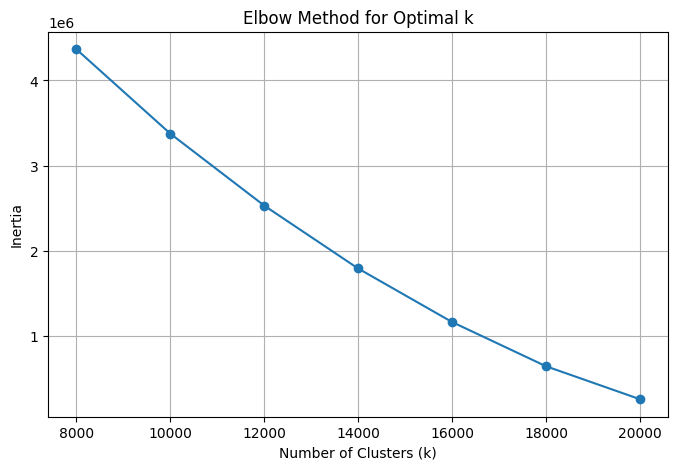

In [23]:
k_values = range(8000, 20001, 2000)

# Store the inertia for each k
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pi_embeddings_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()